# Импорт библиотек

In [1]:
import pandas as pd
pd.set_option('display.max_columns',None)

from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from tensorflow import keras

from lightgbm import LGBMClassifier

from tqdm.notebook import tqdm

import numpy as np

import scipy.stats as stats

import time

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt

import seaborn as sns

# Первичный осмотр

In [2]:
train = pd.read_csv('train.csv')
feats = pd.read_csv('players_feats.csv')
test = pd.read_csv('test.csv')

In [3]:
for data_frame in (train, test, feats):
    display(data_frame.head())
    display(data_frame.describe().transpose())
    data_frame.info(verbose=True, show_counts=True)
    print('*** ' * 16)

,map_id,team1_id,team2_id,map_name,who_win
0,289,6665,7718,Ancient,0
1,715,4411,10577,Inferno,0
2,157,11251,9455,Nuke,1
3,524,4608,7532,Mirage,0
4,404,8637,6667,Overpass,1


,count,mean,std,min,25%,50%,75%,max
map_id,713.0,370.925666,214.994673,0.0,184.0,371.0,557.0,742.0
team1_id,713.0,7243.643759,2192.674445,4411.0,5005.0,6667.0,9215.0,11726.0
team2_id,713.0,7787.844320,2318.184057,4411.0,5973.0,7532.0,9565.0,11726.0
who_win,713.0,0.458626,0.498635,0.0,0.0,0.0,1.0,1.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 713 entries, 0 to 712
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   map_id    713 non-null    int64 
 1   team1_id  713 non-null    int64 
 2   team2_id  713 non-null    int64 
 3   map_name  713 non-null    object
 4   who_win   713 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 28.0+ KB
*** *** *** *** *** *** *** *** *** *** *** *** *** *** *** *** 


,index,map_id,team1_id,team2_id,map_name
0,713,309,5973,5752,Dust2
1,714,541,5973,5752,Vertigo
2,715,1,8297,7020,Nuke
3,716,392,8297,7020,Mirage
4,717,684,8297,7020,Overpass


,count,mean,std,min,25%,50%,75%,max
index,30.0,727.500000,8.803408,713.0,720.25,727.5,734.75,742.0
map_id,30.0,372.766667,209.293176,1.0,217.00,374.5,535.25,684.0
team1_id,30.0,5721.500000,1403.423542,4494.0,4608.00,4608.0,6666.50,8297.0
team2_id,30.0,6629.800000,1009.559528,4411.0,6146.00,6667.0,7020.00,8297.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   index     30 non-null     int64 
 1   map_id    30 non-null     int64 
 2   team1_id  30 non-null     int64 
 3   team2_id  30 non-null     int64 
 4   map_name  30 non-null     object
dtypes: int64(4), object(1)
memory usage: 1.3+ KB
*** *** *** *** *** *** *** *** *** *** *** *** *** *** *** *** 


,p1_id,p1_total_kills,p1_headshots,p1_total_deaths,p1_kd_ratio,p1_damage_per_round,p1_grenade_damage_per_round,p1_maps_played,p1_rounds_played,p1_kills_per_round,p1_assists_per_round,p1_deaths_per_round,p1_saved_by_teammate_per_round,p1_saved_teammates_per_round,p1_rating,p1_kill_death,p1_kill_round,p1_rounds_with_kills,p1_kill_death_difference,p1_total_opening_kills,p1_total_opening_deaths,p1_opening_kill_ratio,p1_opening_kill_rating,p1_team_win_percent_after_first_kill,p1_first_kill_in_won_rounds,p2_id,p2_total_kills,p2_headshots,p2_total_deaths,p2_kd_ratio,p2_damage_per_round,p2_grenade_damage_per_round,p2_maps_played,p2_rounds_played,p2_kills_per_round,p2_assists_per_round,p2_deaths_per_round,p2_saved_by_teammate_per_round,p2_saved_teammates_per_round,p2_rating,p2_kill_death,p2_kill_round,p2_rounds_with_kills,p2_kill_death_difference,p2_total_opening_kills,p2_total_opening_deaths,p2_opening_kill_ratio,p2_opening_kill_rating,p2_team_win_percent_after_first_kill,p2_first_kill_in_won_rounds,p3_id,p3_total_kills,p3_headshots,p3_total_deaths,p3_kd_ratio,p3_damage_per_round,p3_grenade_damage_per_round,p3_maps_played,p3_rounds_played,p3_kills_per_round,p3_assists_per_round,p3_deaths_per_round,p3_saved_by_teammate_per_round,p3_saved_teammates_per_round,p3_rating,p3_kill_death,p3_kill_round,p3_rounds_with_kills,p3_kill_death_difference,p3_total_opening_kills,p3_total_opening_deaths,p3_opening_kill_ratio,p3_opening_kill_rating,p3_team_win_percent_after_first_kill,p3_first_kill_in_won_rounds,p4_id,p4_total_kills,p4_headshots,p4_total_deaths,p4_kd_ratio,p4_damage_per_round,p4_grenade_damage_per_round,p4_maps_played,p4_rounds_played,p4_kills_per_round,p4_assists_per_round,p4_deaths_per_round,p4_saved_by_teammate_per_round,p4_saved_teammates_per_round,p4_rating,p4_kill_death,p4_kill_round,p4_rounds_with_kills,p4_kill_death_difference,p4_total_opening_kills,p4_total_opening_deaths,p4_opening_kill_ratio,p4_opening_kill_rating,p4_team_win_percent_after_first_kill,p4_first_kill_in_won_rounds,p5_id,p5_total_kills,p5_headshots,p5_total_deaths,p5_kd_ratio,p5_damage_per_round,p5_grenade_damage_per_round,p5_maps_played,p5_rounds_played,p5_kills_per_round,p5_assists_per_round,p5_deaths_per_round,p5_saved_by_teammate_per_round,p5_saved_teammates_per_round,p5_rating,p5_kill_death,p5_kill_round,p5_rounds_with_kills,p5_kill_death_difference,p5_total_opening_kills,p5_total_opening_deaths,p5_opening_kill_ratio,p5_opening_kill_rating,p5_team_win_percent_after_first_kill,p5_first_kill_in_won_rounds,team_id,map_name,map_id
0,4954,90,42.2,112,0.80,76.3,5.9,6,156,0.58,0.24,0.72,0.13,0.05,0.98,0.80,0.58,62,-22,10,13,0.77,0.85,60.0,8.2,7412,106,35.8,119,0.89,66.8,5.6,7,181,0.59,0.09,0.66,0.07,0.06,0.91,0.89,0.59,75,-13,17,27,0.63,0.89,82.4,15.4,9078,46,65.2,54,0.85,76.9,4.5,3,75,0.61,0.16,0.72,0.07,0.07,0.93,0.85,0.61,34,-8,4,14,0.29,0.62,50.0,5.0,13843,110,40.9,139,0.79,53.8,3.0,8,204,0.54,0.06,0.68,0.06,0.09,0.83,0.79,0.54,80,-29,15,20,0.75,0.87,53.3,8.2,15165,140,40.7,133,1.05,83.9,9.2,8,198,0.71,0.17,0.67,0.07,0.07,1.16,1.04,0.70,84,5,25,12,2.08,1.28,84.0,25.0,6665,Ancient,635
1,5794,45,60.0,57,0.79,82.3,10.9,3,68,0.66,0.15,0.84,0.07,0.07,0.90,0.79,0.66,30,-12,5,10,0.50,0.79,40.0,10.0,5796,34,50.0,51,0.67,59.0,4.7,3,68,0.50,0.10,0.75,0.04,0.07,0.71,0.67,0.50,27,-17,5,4,1.25,0.94,0.0,0.0,7266,38,42.1,51,0.75,61.0,2.3,3,68,0.56,0.07,0.75,0.03,0.06,0.74,0.75,0.56,25,-13,6,8,0.75,0.91,83.3,25.0,12781,27,33.3,53,0.51,50.4,5.3,3,68,0.40,0.04,0.78,0.01,0.03,0.56,0.51,0.40,22,-26,7,13,0.54,0.86,57.1,20.0,14932,504,55.0,370,1.36,85.8,3.9,23,599,0.84,0.12,0.62,0.08,0.12,1.28,1.36,0.86,233,96,54,34,1.59,1.17,70.4,16.7,7532,Ancient,635
2,4954,156,51.9,167,0.93,63.5,3.4,10,265,0.59,0.10,0.63,0.11,0.11,0.95,0.93,0.59,107,-11,21,18,1.17,0.95,81.0,13.1,7412,125,35.2,135,0.93,68.7,5.7,8,211,0.59,0.13,0.64,0.07,0.07,0.98,0.93,0.59,91,-10,29,25,1.16,1.16,69.0,20.0,9078,73,50.7,79,0.92,72.0,1.2,4,109,0.67,0.12,0.72,0.13,0.06,0.98,0.92,0.67,43,-6,14,21,0.67,0.99,50.0,13.0,138

,count,mean,std,min,25%,50%,75%,max
p1_id,1486.0,6808.845222,4031.792795,29.0,3669.000,7938.00,9115.000,14359.00
p1_total_kills,1486.0,237.353297,126.932320,0.0,148.000,224.00,307.000,769.00
p1_headshots,1486.0,45.623553,9.999153,0.0,41.000,46.70,51.100,81.80
p1_total_deaths,1486.0,239.849260,124.403672,0.0,156.000,227.00,310.750,711.00
p1_kd_ratio,1486.0,0.990875,0.237200,0.0,0.870,0.96,1.080,3.89
...,...,...,...,...,...,...,...,...
p5_opening_kill_rating,1486.0,0.966097,0.284628,0.0,0.900,1.00,1.110,2.15
p5_team_win_percent_after_first_kill,1482.0,69.634615,20.948070,0.0,66.700,74.25,81.075,100.00
p5_first_kill_in_won_rounds,1486.0,13.871400,6.240919,0.0,10.525,13.80,17.700,50.00
team_id,1486.0,7461.635262,2255.926813,4411.0,5752.000,7020.00,9455.000,11726.00


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1486 entries, 0 to 1485
Data columns (total 128 columns):
 #    Column                                Non-Null Count  Dtype  
---   ------                                --------------  -----  
 0    p1_id                                 1486 non-null   int64  
 1    p1_total_kills                        1486 non-null   int64  
 2    p1_headshots                          1486 non-null   float64
 3    p1_total_deaths                       1486 non-null   int64  
 4    p1_kd_ratio                           1486 non-null   float64
 5    p1_damage_per_round                   1486 non-null   float64
 6    p1_grenade_damage_per_round           1486 non-null   float64
 7    p1_maps_played                        1486 non-null   int64  
 8    p1_rounds_played                      1486 non-null   int64  
 9    p1_kills_per_round                    1486 non-null   float64
 10   p1_assists_per_round                  1486 non-null   float64
 11   p1

Видно, что таблицы в порядке типы соответсвуют ожидаемым. Недостатка всего 2: в таблице `test` есть бесполезный столбец *index* и в датасете `feats` есть пропуски.

Посмотрим в каких они колонках.

In [4]:
test = test.drop('index', axis=1)

In [5]:
feats.isna().sum().sort_values(ascending=False).head(10)

p3_team_win_percent_after_first_kill    4
p4_team_win_percent_after_first_kill    4
p5_team_win_percent_after_first_kill    4
p1_team_win_percent_after_first_kill    3
p2_team_win_percent_after_first_kill    3
p4_saved_by_teammate_per_round          0
p4_rounds_played                        0
p4_kills_per_round                      0
p4_assists_per_round                    0
p4_deaths_per_round                     0
dtype: int64

Все пропуски находятся в категории *team_win_percent_after_first_kill*

In [6]:
feats.loc[feats.isna().sum(axis=1) > 0, :]

,p1_id,p1_total_kills,p1_headshots,p1_total_deaths,p1_kd_ratio,p1_damage_per_round,p1_grenade_damage_per_round,p1_maps_played,p1_rounds_played,p1_kills_per_round,p1_assists_per_round,p1_deaths_per_round,p1_saved_by_teammate_per_round,p1_saved_teammates_per_round,p1_rating,p1_kill_death,p1_kill_round,p1_rounds_with_kills,p1_kill_death_difference,p1_total_opening_kills,p1_total_opening_deaths,p1_opening_kill_ratio,p1_opening_kill_rating,p1_team_win_percent_after_first_kill,p1_first_kill_in_won_rounds,p2_id,p2_total_kills,p2_headshots,p2_total_deaths,p2_kd_ratio,p2_damage_per_round,p2_grenade_damage_per_round,p2_maps_played,p2_rounds_played,p2_kills_per_round,p2_assists_per_round,p2_deaths_per_round,p2_saved_by_teammate_per_round,p2_saved_teammates_per_round,p2_rating,p2_kill_death,p2_kill_round,p2_rounds_with_kills,p2_kill_death_difference,p2_total_opening_kills,p2_total_opening_deaths,p2_opening_kill_ratio,p2_opening_kill_rating,p2_team_win_percent_after_first_kill,p2_first_kill_in_won_rounds,p3_id,p3_total_kills,p3_headshots,p3_total_deaths,p3_kd_ratio,p3_damage_per_round,p3_grenade_damage_per_round,p3_maps_played,p3_rounds_played,p3_kills_per_round,p3_assists_per_round,p3_deaths_per_round,p3_saved_by_teammate_per_round,p3_saved_teammates_per_round,p3_rating,p3_kill_death,p3_kill_round,p3_rounds_with_kills,p3_kill_death_difference,p3_total_opening_kills,p3_total_opening_deaths,p3_opening_kill_ratio,p3_opening_kill_rating,p3_team_win_percent_after_first_kill,p3_first_kill_in_won_rounds,p4_id,p4_total_kills,p4_headshots,p4_total_deaths,p4_kd_ratio,p4_damage_per_round,p4_grenade_damage_per_round,p4_maps_played,p4_rounds_played,p4_kills_per_round,p4_assists_per_round,p4_deaths_per_round,p4_saved_by_teammate_per_round,p4_saved_teammates_per_round,p4_rating,p4_kill_death,p4_kill_round,p4_rounds_with_kills,p4_kill_death_difference,p4_total_opening_kills,p4_total_opening_deaths,p4_opening_kill_ratio,p4_opening_kill_rating,p4_team_win_percent_after_first_kill,p4_first_kill_in_won_rounds,p5_id,p5_total_kills,p5_headshots,p5_total_deaths,p5_kd_ratio,p5_damage_per_round,p5_grenade_damage_per_round,p5_maps_played,p5_rounds_played,p5_kills_per_round,p5_assists_per_round,p5_deaths_per_round,p5_saved_by_teammate_per_round,p5_saved_teammates_per_round,p5_rating,p5_kill_death,p5_kill_round,p5_rounds_with_kills,p5_kill_death_difference,p5_total_opening_kills,p5_total_opening_deaths,p5_opening_kill_ratio,p5_opening_kill_rating,p5_team_win_percent_after_first_kill,p5_first_kill_in_won_rounds,team_id,map_name,map_id
13,11154,242,41.3,187,1.29,78.3,3.0,13,325,0.74,0.12,0.58,0.10,0.12,1.16,1.26,0.74,28,8,5,3,1.67,1.04,80.0,19.0,14390,470,23.4,452,1.04,73.3,3.8,28,713,0.66,0.13,0.63,0.09,0.05,1.06,0.49,0.42,14,-18,2,6,0.33,0.67,100.0,25.0,14394,526,54.2,462,1.14,76.5,1.9,28,713,0.74,0.14,0.65,0.10,0.13,1.13,0.94,0.78,22,-2,2,3,0.67,0.79,0.0,0.0,17861,451,40.8,401,1.12,81.9,6.2,25,633,0.71,0.18,0.63,0.09,0.09,1.18,0.59,0.50,14,-14,4,5,0.80,0.96,50.0,25.0,20987,104,67.3,117,0.89,69.7,3.0,6,164,0.63,0.12,0.71,0.09,0.10,0.95,0.75,0.48,8,-4,0,3,0.00,0.47,NaN,0.0,9215,Nuke,18
282,8611,62,33.9,69,0.90,64.4,5.5,4,100,0.62,0.08,0.69,0.13,0.16,0.96,0.90,0.62,43,-7,7,10,0.70,0.85,71.4,12.5,9278,14,50.0,18,0.78,82.7,6.1,1,22,0.64,0.05,0.82,0.05,0.00,0.73,0.78,0.64,9,-4,0,4,0.00,0.36,NaN,0.0,9766,10,50.0,21,0.48,63.9,0.7,1,22,0.45,0.23,0.95,0.09,0.14,0.56,0.48,0.45,7,-11,1,1,1.00,0.82,100.0,16.7,14218,8,37.5,18,0.44,45.7,8.0,1,22,0.36,0.05,0.82,0.05,0.05,0.50,0.44,0.36,5,-10,1,2,0.50,0.74,100.0,16.7,16726,445,24.7,357,1.25,80.1,3.1,22,568,0.78,0.14,0.63,0.09,0.11,1.19,1.12,0.75,101,16,23,16,1.44,1.12,73.9,18.9,4411,Vertigo,21
309,9216,244,44.7,234,1.04,75.0,2.1,13,356,0.69,0.08,0.66,0.07,0.07,1.04,0.58,0.52,8,-8,0,4,0.00,0.35,NaN,0.0,11329,235,57.4,241,0.98,74.1,4.7,12,353,0.67,0.10,0.68,0.09,0.11,1.03,0.00,0.00,0,0,0,0,0.00,0.00,0.0,0.0,11617,379,63.6,415,0.91,73.4,3.4,21,559,0.68,0.10,0.74,0.12,0.09,0.98,0.77,0.66,85,-36,18,29,0.62,0.89,55.6,13.9,16816,237,53.2,

Можно заметить, что когда в *team_win_percent_after_first_kill* встречается NaN, *first_kill_in_won_rounds* равна нулю. Что вполне логично, если не было первого убиства в раунде, то и процент выйгранных раундов с первым убийством неясно как считать. Однако, видно что в других случаях, когда *first_kill_in_won_rounds* равна нулю, тогда и *team_win_percent_after_first_kill* равна нулю. Значит все эти NaN  можно заменить на нули.

In [7]:
feats = feats.fillna(0)

# Подготовка данных

Перед объединением таблиц `train` и `feats` удалим из `feats` столбцы с id игроков (они не помогут в предсказании) и *map_name* (она повторяется в `train`)

In [8]:
id_columns = feats.columns.str.startswith('p') & feats.columns.str.endswith('id') # Все колонки начинающиеся на p и кончающиеся на id
feats = feats.loc[:, ~id_columns]
feats = feats.drop('map_name', axis=1)

Теперь объеденим таблицы 3-мя разными способами:

## Первый способ
Просто объединим все данные. И уберем все столбцы ненужные после объединения, которые не помогут в предсказании (все id).

Также имеет смысл отсортировать игоков по их вкладу в победу от большего к меньшему для каждой команды. Поскольку метрики "вклада в победу" не существует возмем в качестве заменителя соотношение k/d. Исходя из предположения, что если игрок много убивает и мало убивает, то он хорош.

In [9]:
# Фунция пригодится и для преобразования тестовой выборки
def merge_big(df):
    # Объединяем
    df_big = df.merge(feats, left_on=['map_id', 'team1_id'], right_on=['map_id', 'team_id'])
    df_big = df_big.merge(feats, left_on=['map_id', 'team2_id'], right_on=['map_id', 'team_id'])
    
    # Сортируем по уменьшению kd_ratio
    id_columns_x = df_big.columns.str.endswith('x')# Все колонки кончающиеся на x
    df_big_x = df_big.loc[:, id_columns_x]
    df_big_x_sorted = df_big_x.copy()
    id_columns_y = df_big.columns.str.endswith('y')# Все колонки кончающиеся на y
    df_big_y = df_big.loc[:, id_columns_y]
    df_big_y_sorted = df_big_y.copy()
    
    id_columns_kd = df_big_x.columns.str.endswith('kd_ratio_x')
    kd_col_num = [df_big_x.columns.get_loc(col) for col in df_big_x.columns[id_columns_kd]]
    for i in df_big.index:
        order_x = df_big_x.iloc[i, kd_col_num].sort_values(ascending=False).index.str[:2]
        order_y = df_big_y.iloc[i, kd_col_num].sort_values(ascending=False).index.str[:2]
        for original, sorted_x, sorted_y in zip(('p1', 'p2', 'p3', 'p4', 'p5') , order_x, order_y):
            df_big_x_sorted.loc[i, df_big_x.columns.str.startswith(original)] = np.array(df_big_x.loc[i, df_big_x.columns.str.startswith(sorted_x)])
            df_big_y_sorted.loc[i, df_big_y.columns.str.startswith(original)] = np.array(df_big_y.loc[i, df_big_y.columns.str.startswith(sorted_y)])
    try:
        df_big = df_big.loc[:, ['map_name', 'who_win']].join(df_big_x_sorted).join(df_big_y_sorted)
    except:
        df_big = df_big.loc[:, ['map_name']].join(df_big_x_sorted).join(df_big_y_sorted)
    
    # Удаляем столбцы
    id_columns_big = df_big.columns.str.endswith('id') | df_big.columns.str.endswith('id_x') | df_big.columns.str.endswith('id_y')
    df_big = df_big.loc[:, ~id_columns_big]
    return df_big

In [10]:
train_big = merge_big(train)
train_big.head()

,map_name,who_win,p1_total_kills_x,p1_headshots_x,p1_total_deaths_x,p1_kd_ratio_x,p1_damage_per_round_x,p1_grenade_damage_per_round_x,p1_maps_played_x,p1_rounds_played_x,p1_kills_per_round_x,p1_assists_per_round_x,p1_deaths_per_round_x,p1_saved_by_teammate_per_round_x,p1_saved_teammates_per_round_x,p1_rating_x,p1_kill_death_x,p1_kill_round_x,p1_rounds_with_kills_x,p1_kill_death_difference_x,p1_total_opening_kills_x,p1_total_opening_deaths_x,p1_opening_kill_ratio_x,p1_opening_kill_rating_x,p1_team_win_percent_after_first_kill_x,p1_first_kill_in_won_rounds_x,p2_total_kills_x,p2_headshots_x,p2_total_deaths_x,p2_kd_ratio_x,p2_damage_per_round_x,p2_grenade_damage_per_round_x,p2_maps_played_x,p2_rounds_played_x,p2_kills_per_round_x,p2_assists_per_round_x,p2_deaths_per_round_x,p2_saved_by_teammate_per_round_x,p2_saved_teammates_per_round_x,p2_rating_x,p2_kill_death_x,p2_kill_round_x,p2_rounds_with_kills_x,p2_kill_death_difference_x,p2_total_opening_kills_x,p2_total_opening_deaths_x,p2_opening_kill_ratio_x,p2_opening_kill_rating_x,p2_team_win_percent_after_first_kill_x,p2_first_kill_in_won_rounds_x,p3_total_kills_x,p3_headshots_x,p3_total_deaths_x,p3_kd_ratio_x,p3_damage_per_round_x,p3_grenade_damage_per_round_x,p3_maps_played_x,p3_rounds_played_x,p3_kills_per_round_x,p3_assists_per_round_x,p3_deaths_per_round_x,p3_saved_by_teammate_per_round_x,p3_saved_teammates_per_round_x,p3_rating_x,p3_kill_death_x,p3_kill_round_x,p3_rounds_with_kills_x,p3_kill_death_difference_x,p3_total_opening_kills_x,p3_total_opening_deaths_x,p3_opening_kill_ratio_x,p3_opening_kill_rating_x,p3_team_win_percent_after_first_kill_x,p3_first_kill_in_won_rounds_x,p4_total_kills_x,p4_headshots_x,p4_total_deaths_x,p4_kd_ratio_x,p4_damage_per_round_x,p4_grenade_damage_per_round_x,p4_maps_played_x,p4_rounds_played_x,p4_kills_per_round_x,p4_assists_per_round_x,p4_deaths_per_round_x,p4_saved_by_teammate_per_round_x,p4_saved_teammates_per_round_x,p4_rating_x,p4_kill_death_x,p4_kill_round_x,p4_rounds_with_kills_x,p4_kill_death_difference_x,p4_total_opening_kills_x,p4_total_opening_deaths_x,p4_opening_kill_ratio_x,p4_opening_kill_rating_x,p4_team_win_percent_after_first_kill_x,p4_first_kill_in_won_rounds_x,p5_total_kills_x,p5_headshots_x,p5_total_deaths_x,p5_kd_ratio_x,p5_damage_per_round_x,p5_grenade_damage_per_round_x,p5_maps_played_x,p5_rounds_played_x,p5_kills_per_round_x,p5_assists_per_round_x,p5_deaths_per_round_x,p5_saved_by_teammate_per_round_x,p5_saved_teammates_per_round_x,p5_rating_x,p5_kill_death_x,p5_kill_round_x,p5_rounds_with_kills_x,p5_kill_death_difference_x,p5_total_opening_kills_x,p5_total_opening_deaths_x,p5_opening_kill_ratio_x,p5_opening_kill_rating_x,p5_team_win_percent_after_first_kill_x,p5_first_kill_in_won_rounds_x,p1_total_kills_y,p1_headshots_y,p1_total_deaths_y,p1_kd_ratio_y,p1_damage_per_round_y,p1_grenade_damage_per_round_y,p1_maps_played_y,p1_rounds_played_y,p1_kills_per_round_y,p1_assists_per_round_y,p1_deaths_per_round_y,p1_saved_by_teammate_per_round_y,p1_saved_teammates_per_round_y,p1_rating_y,p1_kill_death_y,p1_kill_round_y,p1_rounds_with_kills_y,p1_kill_death_difference_y,p1_total_opening_kills_y,p1_total_opening_deaths_y,p1_opening_kill_ratio_y,p1_opening_kill_rating_y,p1_team_win_percent_after_first_kill_y,p1_first_kill_in_won_rounds_y,p2_total_kills_y,p2_headshots_y,p2_total_deaths_y,p2_kd_ratio_y,p2_damage_per_round_y,p2_grenade_damage_per_round_y,p2_maps_played_y,p2_rounds_played_y,p2_kills_per_round_y,p2_assists_per_round_y,p2_deaths_per_round_y,p2_saved_by_teammate_per_round_y,p2_saved_teammates_per_round_y,p2_rating_y,p2_kill_death_y,p2_kill_round_y,p2_rounds_with_kills_y,p2_kill_death_difference_y,p2_total_opening_kills_y,p2_total_opening_deaths_y,p2_opening_kill_ratio_y,p2_opening_kill_rating_y,p2_team_win_percent_after_first_kill_y,p2_first_kill_in_won_rounds_y,p3_total_kills_y,p3_headshots_y,p3_total_deaths_y,p3_kd_ratio_y,p3_damage_per_round_y,p3_grenade_damage_per_round_y,p3_maps_played_y,p3_rounds_played_y,p3_kills_per_ro

In [11]:
train_big.shape

(713, 242)

Отлично, теперь игроки в командах рассортированы по *kd_ratio* в порядке уменьшения

Данный способ предполагает обучение модели на практически сырых данных. Без превентивной попытки снизить количество параметров.

## Второй способ
Сократим количество параметров вдвое.
Логика такая: разница между победой и поражением - это разница между индивидуальными параметрами игроков разных команд. Таким образом фичами в данном случае будет разница в каждом параметре между игроками противоборствующих комманд.

In [12]:
# Фунция пригодится и для преобразования тестовой выборки
def merge_diff(df):
    # Объединяем
    df_big = df.merge(feats, left_on=['map_id', 'team1_id'], right_on=['map_id', 'team_id'])
    df_big = df_big.merge(feats, left_on=['map_id', 'team2_id'], right_on=['map_id', 'team_id'])
    
    # Сортируем 
    id_columns_x = df_big.columns.str.endswith('x')# Все колонки кончающиеся на x
    df_big_x = df_big.loc[:, id_columns_x]
    df_big_x_sorted = df_big_x.copy()
    id_columns_y = df_big.columns.str.endswith('y')# Все колонки кончающиеся на y
    df_big_y = df_big.loc[:, id_columns_y]
    df_big_y_sorted = df_big_y.copy()
    
    id_columns_kd = df_big_x.columns.str.endswith('kd_ratio_x')
    kd_col_num = [df_big_x.columns.get_loc(col) for col in df_big_x.columns[id_columns_kd]]
    for i in df_big.index:
        order_x = df_big_x.iloc[i, kd_col_num].sort_values(ascending=False).index.str[:2]
        order_y = df_big_y.iloc[i, kd_col_num].sort_values(ascending=False).index.str[:2]
        for original, sorted_x, sorted_y in zip(('p1', 'p2', 'p3', 'p4', 'p5') , order_x, order_y):
            df_big_x_sorted.loc[i, df_big_x.columns.str.startswith(original)] = np.array(df_big_x.loc[i, df_big_x.columns.str.startswith(sorted_x)])
            df_big_y_sorted.loc[i, df_big_y.columns.str.startswith(original)] = np.array(df_big_y.loc[i, df_big_y.columns.str.startswith(sorted_y)])
    
    df_big_x_sorted.columns = df_big_x_sorted.columns.str[:-2]
    df_big_y_sorted.columns = df_big_y_sorted.columns.str[:-2]
    try:
        df_big = df_big.loc[:, ['map_name', 'who_win']].join(df_big_x_sorted - df_big_y_sorted)
    except:
        df_big = df_big.loc[:, ['map_name']].join(df_big_x_sorted - df_big_y_sorted)
    
    # Удаляем столбцы
    id_columns_big = df_big.columns.str.endswith('id') | df_big.columns.str.endswith('id_x') | df_big.columns.str.endswith('id_y')
    df_big = df_big.loc[:, ~id_columns_big]
    return df_big

In [13]:
train_diff = merge_diff(train)
train_diff.head()

,map_name,who_win,p1_total_kills,p1_headshots,p1_total_deaths,p1_kd_ratio,p1_damage_per_round,p1_grenade_damage_per_round,p1_maps_played,p1_rounds_played,p1_kills_per_round,p1_assists_per_round,p1_deaths_per_round,p1_saved_by_teammate_per_round,p1_saved_teammates_per_round,p1_rating,p1_kill_death,p1_kill_round,p1_rounds_with_kills,p1_kill_death_difference,p1_total_opening_kills,p1_total_opening_deaths,p1_opening_kill_ratio,p1_opening_kill_rating,p1_team_win_percent_after_first_kill,p1_first_kill_in_won_rounds,p2_total_kills,p2_headshots,p2_total_deaths,p2_kd_ratio,p2_damage_per_round,p2_grenade_damage_per_round,p2_maps_played,p2_rounds_played,p2_kills_per_round,p2_assists_per_round,p2_deaths_per_round,p2_saved_by_teammate_per_round,p2_saved_teammates_per_round,p2_rating,p2_kill_death,p2_kill_round,p2_rounds_with_kills,p2_kill_death_difference,p2_total_opening_kills,p2_total_opening_deaths,p2_opening_kill_ratio,p2_opening_kill_rating,p2_team_win_percent_after_first_kill,p2_first_kill_in_won_rounds,p3_total_kills,p3_headshots,p3_total_deaths,p3_kd_ratio,p3_damage_per_round,p3_grenade_damage_per_round,p3_maps_played,p3_rounds_played,p3_kills_per_round,p3_assists_per_round,p3_deaths_per_round,p3_saved_by_teammate_per_round,p3_saved_teammates_per_round,p3_rating,p3_kill_death,p3_kill_round,p3_rounds_with_kills,p3_kill_death_difference,p3_total_opening_kills,p3_total_opening_deaths,p3_opening_kill_ratio,p3_opening_kill_rating,p3_team_win_percent_after_first_kill,p3_first_kill_in_won_rounds,p4_total_kills,p4_headshots,p4_total_deaths,p4_kd_ratio,p4_damage_per_round,p4_grenade_damage_per_round,p4_maps_played,p4_rounds_played,p4_kills_per_round,p4_assists_per_round,p4_deaths_per_round,p4_saved_by_teammate_per_round,p4_saved_teammates_per_round,p4_rating,p4_kill_death,p4_kill_round,p4_rounds_with_kills,p4_kill_death_difference,p4_total_opening_kills,p4_total_opening_deaths,p4_opening_kill_ratio,p4_opening_kill_rating,p4_team_win_percent_after_first_kill,p4_first_kill_in_won_rounds,p5_total_kills,p5_headshots,p5_total_deaths,p5_kd_ratio,p5_damage_per_round,p5_grenade_damage_per_round,p5_maps_played,p5_rounds_played,p5_kills_per_round,p5_assists_per_round,p5_deaths_per_round,p5_saved_by_teammate_per_round,p5_saved_teammates_per_round,p5_rating,p5_kill_death,p5_kill_round,p5_rounds_with_kills,p5_kill_death_difference,p5_total_opening_kills,p5_total_opening_deaths,p5_opening_kill_ratio,p5_opening_kill_rating,p5_team_win_percent_after_first_kill,p5_first_kill_in_won_rounds
0,Ancient,0,31,2.8,21,0.04,5.5,2.1,1,27,0.06,0.03,0.03,0.07,0.06,0.01,0.04,0.06,26,10,-6,5,-1.57,-0.23,11.1,-4.8,192,-9.2,146,0.13,9.7,3.3,9,248,0.05,0.01,-0.03,0.02,0.01,0.17,0.13,0.05,128,46,39,12,0.91,0.27,27.4,9.0,223,1.4,172,0.15,7.6,-1.2,9,248,0.10,0.02,-0.02,0.00,0.02,0.15,0.15,0.10,134,51,36,32,0.06,-0.03,5.4,-4.1,157,-14.5,163,0.10,2.4,2.8,10,271,0.02,0.05,-0.06,0.09,-0.02,0.12,0.10,0.02,116,-6,26,27,0.32,0.16,5.2,4.7,162,-6.8,163,0.13,1.4,-0.3,10,271,0.03,-0.03,-0.08,-0.08,0.03,0.07,0.13,0.03,104,-1,21,35,-0.29,-0.13,2.4,-5.3
1,Inferno,0,-235,33.2,-121,-0.33,6.9,6.0,-11,-280,-0.09,0.04,0.09,0.02,0.01,-0.09,-0.41,-0.13,-49,-86,-4,27,-1.41,-0.10,0.0,-0.1,-369,1.0,-205,-0.35,-20.3,-8.9,-15,-393,-0.14,-0.05,0.06,0.05,-0.01,-0.28,-0.31,-0.15,-111,-108,-38,-9,-0.63,-0.24,11.7,-2.2,-309,-21.9,-221,-0.19,-2.6,6.1,-15,-393,-0.06,0.04,0.07,-0.01,0.00,-0.14,-0.18,-0.06,-83,-64,9,28,-0.34,0.09,-11.5,5.6,-254,-12.5,-233,-0.08,3.2,4.9,-15,-393,-0.02,0.07,0.03,0.02,0.01,0.01,-0.01,0.02,-58,4,-5,-13,0.12,0.07,-0.5,3.8,-292,-15.0,-331,-0.01,2.0,-0.3,-20,-516,0.00,0.03,0.01,-0.04,0.04,-0.03,0.03,0.01,-82,36,-32,-60,0.81,0.03,-9.2,-2.8
2,Nuke,1,209,7.2,183,-0.09,5.9,0.3,9,259,-0.02,0.03,0.03,0.03,-0.04,0.06,-0.16,-0.07,66,-15,54,28,0.22,0.39,12.6,15.1,201,-4.2,145,0.11,3.0,-1.1,9,259,0.05,-0.01,-0.01,-0.04,-0.03,0.05,0.13,0.05,89,33,14,5,0.32,0.02,14.9,0.7,67,3.0,47,0.06,-5.8,1.3,4,121,-0.04,-0.03,-0.07,0.00,0.01,-0.08,0.23,0.09,49,40,-21,-14,-0.39,-0.36,28.7,-10.5,221,22.2,191,0.0

In [14]:
train_diff.shape

(713, 122)

Таким образом количество признаков было сокращено в 2 раза.

Однако есть способ умеьшить его еще сильнее.

## Третий способ
Поскольку CS:GO это командная игра, то можно усреднить параметры разных игроков одной команды, а после вычислить разницу данных параметров у противоборствующих команд.
Это позволит сокатить количество фичей в 10 раз.

In [15]:
feats_mean_diff = feats.drop('team_id', axis=1)
feats_mean_diff = feats_mean_diff.transpose()
feats_mean_diff['parameter'] = feats_mean_diff.index.str[3:] # Отделим параметр от игрока
feats_mean_diff.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711,712,713,714,715,716,717,718,719,720,721,722,723,724,725,726,727,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784,785,786,787,788,789,790,791,792,793,794,795,796,797,798,799,800,801,802,803,804,805,806,807,808,809,810,811,812,813,814,815,816,817,818,819,820,821,822,823,824,825,826,827,828,829,830,831,832,833,834,835,836,837,838,839,840,841,842,843,844,845,846,847,848,849,850,851,852,853,854,855,856,857,858,859,860,861,862,863,864,865,866,867,868,869,870,871,872,873,874,875,876,877,878,879,880,881,882,883,884,885,886,887,888,889,890,891,892,893,894,895,896,897,898,899,900,901,902,903,904,905,906,907,908,909,910,911,912,913,914,915,916,917,918,919,920,921,922,923,924,925,926,927,928,929,930,931,932,933,934,935,936,937,938,939,940,941,942,943,944,945,946,947,948,949,950,951,952,953,954,955,956,957,958,959,960,961,962,963,964,965,966,967,968,969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,1010,1011,1012,1013,1014,1015,1016,1017,1018,1019,1020,1021

In [16]:
feats_mean_diff = feats_mean_diff.groupby('parameter').mean() # и вычислим среднее для каждого параметра по игрокам
feats_mean_diff = feats_mean_diff.transpose().groupby('_id').diff().dropna()
feats_mean_diff['map_id'] = feats['map_id'].unique()
feats_mean_diff.head()

parameter,assists_per_round,damage_per_round,deaths_per_round,first_kill_in_won_rounds,grenade_damage_per_round,headshots,kd_ratio,kill_death,kill_death_difference,kill_round,kills_per_round,maps_played,opening_kill_rating,opening_kill_ratio,rating,rounds_played,rounds_with_kills,saved_by_teammate_per_round,saved_teammates_per_round,team_win_percent_after_first_kill,total_deaths,total_kills,total_opening_deaths,total_opening_kills,map_id
1,-0.048,-3.84,0.058,1.98,-0.22,3.12,-0.060,-0.058,19.0,-0.008,-0.014,0.6,0.032,0.022,-0.124,11.4,0.4,-0.034,0.002,-15.78,5.0,31.2,-3.4,1.2,635
3,-0.004,4.08,-0.006,0.56,0.10,9.50,0.082,0.082,24.4,0.044,0.046,15.6,-0.006,-0.048,0.084,415.6,168.0,0.006,0.018,8.00,265.2,296.8,38.6,39.0,583
5,-0.016,-6.46,0.016,-5.20,-0.94,-2.08,-0.110,-0.394,-27.2,-0.216,-0.056,3.6,-0.486,-0.776,-0.096,88.8,-93.6,-0.008,0.014,-25.10,51.0,73.0,-16.2,-23.8,439
7,0.014,-5.96,0.058,-1.16,-0.72,-8.20,-0.204,0.104,-21.4,0.114,-0.066,-4.2,0.078,-0.060,-0.152,-117.4,-68.0,0.020,0.000,3.64,-63.0,-94.0,-14.2,-24.2,363
9,-0.016,-1.48,0.068,0.40,0.16,0.02,-0.168,-0.168,-32.4,-0.038,-0.038,-4.4,-0.028,-0.232,-0.110,-99.2,-46.2,-0.006,-0.002,-9.08,-42.4,-74.8,-7.0,-9.8,105


И снова напишем функцию для объединения с `train` и `test`

In [17]:
def merge_mean_diff(df):
    df_mean_diff = df.merge(feats_mean_diff, on='map_id')
    id_columns_mean_diff = df_mean_diff.columns.str.endswith('id')
    df_mean_diff = df_mean_diff.loc[:, ~id_columns_mean_diff]
    return df_mean_diff

In [18]:
train_mean_diff = merge_mean_diff(train)

In [19]:
train_mean_diff.head()

,map_name,who_win,assists_per_round,damage_per_round,deaths_per_round,first_kill_in_won_rounds,grenade_damage_per_round,headshots,kd_ratio,kill_death,kill_death_difference,kill_round,kills_per_round,maps_played,opening_kill_rating,opening_kill_ratio,rating,rounds_played,rounds_with_kills,saved_by_teammate_per_round,saved_teammates_per_round,team_win_percent_after_first_kill,total_deaths,total_kills,total_opening_deaths,total_opening_kills
0,Ancient,0,-0.016,-5.32,0.032,0.10,-1.34,5.26,-0.110,-0.110,-20.0,-0.052,-0.052,-7.8,-0.008,0.114,-0.104,-213.0,-101.6,-0.020,-0.020,-10.30,-133.0,-153.0,-22.2,-23.2
1,Inferno,0,-0.026,2.16,-0.052,-0.86,-1.56,3.04,0.192,0.176,43.6,0.062,0.062,15.2,0.030,0.290,0.106,395.0,76.6,-0.008,-0.010,1.90,222.2,291.8,5.4,14.0
2,Nuke,1,0.028,-1.86,0.000,-1.02,0.30,-9.34,-0.050,-0.058,-13.2,-0.028,-0.028,-8.0,-0.030,0.086,-0.030,-231.4,-70.0,0.002,0.004,-9.72,-146.6,-176.2,-11.2,-17.8
3,Mirage,0,-0.002,-2.42,0.046,-0.50,0.72,-1.22,-0.124,-0.126,-36.0,-0.026,-0.026,-2.2,-0.080,-0.384,-0.090,-59.2,-26.8,0.010,0.010,-3.38,-12.2,-48.8,4.2,-11.0
4,Overpass,1,-0.010,2.50,-0.010,0.46,0.18,4.76,0.052,0.054,9.4,0.020,0.020,-4.4,-0.028,0.036,0.026,-128.8,-7.0,0.004,0.002,2.60,-84.0,-81.8,2.8,-0.8


In [20]:
train_mean_diff.shape

(713, 26)

Теперь, когда признаков стало меньше, можно взгянуть на хитмэп корреляций

<AxesSubplot:>

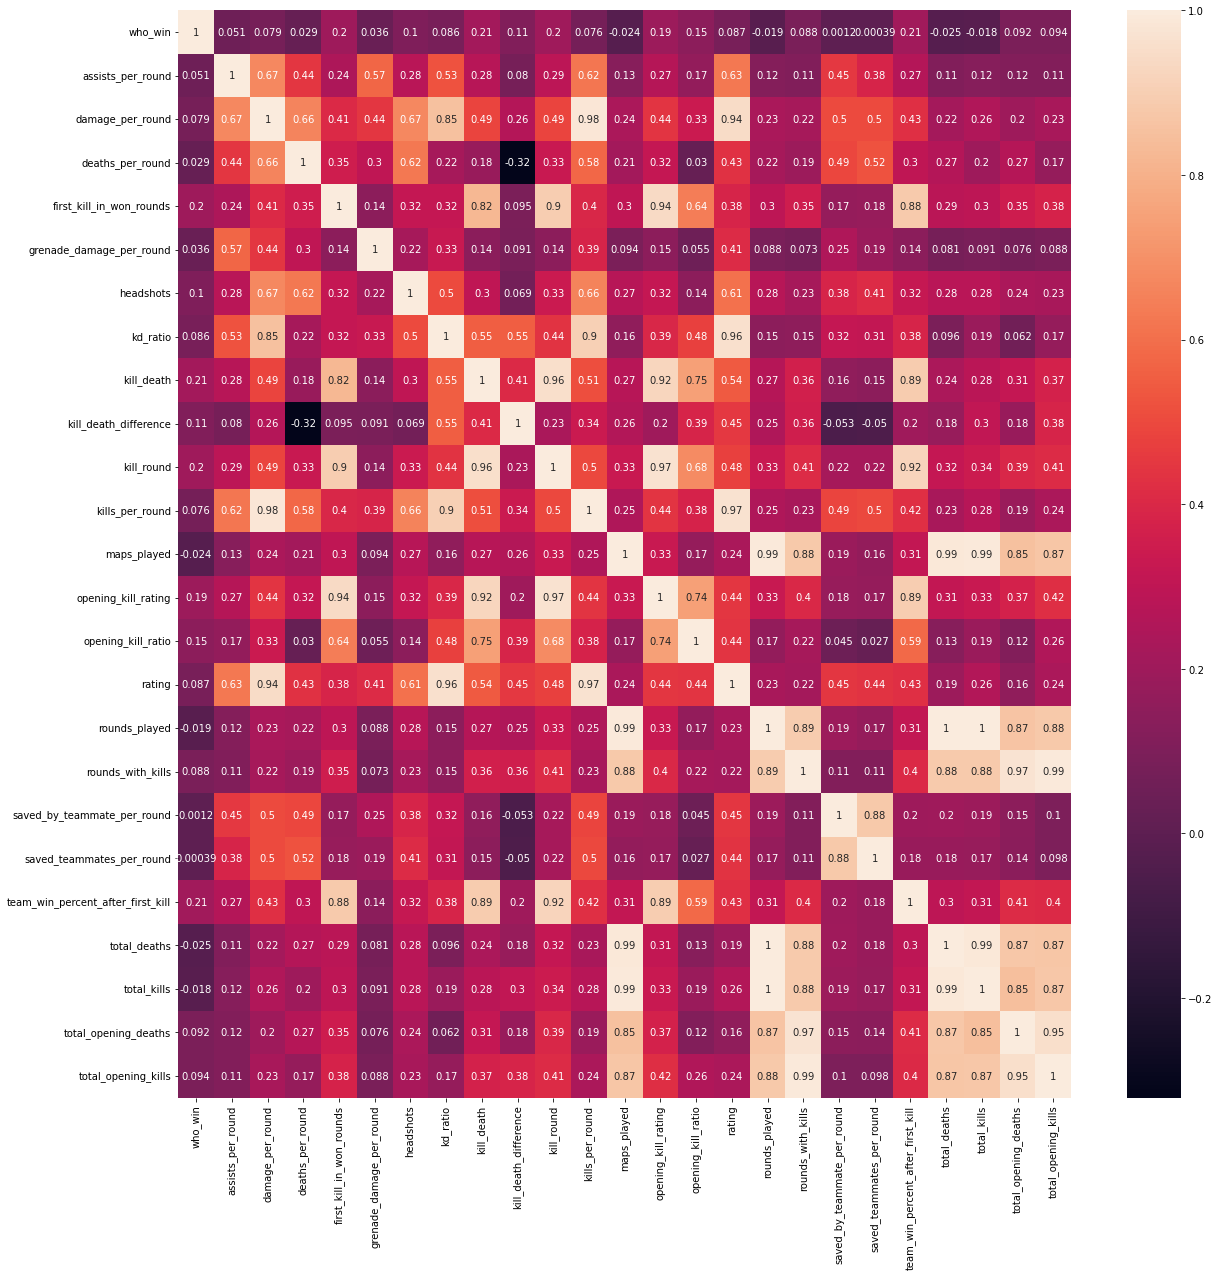

In [21]:
sd = plt.figure(figsize=(20, 20))
sns.heatmap(train_mean_diff.corr(), annot=True)

Видно, что значительное количество параметров коррелирует между собой. Можно сократить количество коррелирующих фичей на следующих этапах.

## Дополнительные размышления
Есть вероятность, что фича *map_name* не будет иметь какого-либо значительного влияния на качество модели, но есть и вероятность, что определенная карта дает преимущество одной из команд (T или CT). А поскольку может быть, что в датафрейме в порядке команд в определенном матче заложена и роль команд, то эта фича может повлиять на результат.

# Обучение модели

Подготовим OHE трансформатор и набор моделей для будущего пайплайна.

In [22]:
transformer = ColumnTransformer(
    [('OHE', OneHotEncoder(drop='first'), ['map_name'])],
    remainder='passthrough'
)
transformer.name = 'ohe'

In [23]:
lr = LogisticRegression(max_iter=1000)
lr.name = 'lr'
el = LogisticRegression(penalty='elasticnet', solver='saga', max_iter=1000, random_state=24)
el.name = 'el'
svc = SVC(random_state=24, probability=True)
svc.name = 'svc'
dtc = DecisionTreeClassifier(random_state=24)
dtc.name = 'dtc'
rfc = RandomForestClassifier(random_state=24)
rfc.name = 'rfc'
lgbmc = LGBMClassifier(random_state=24)
lgbmc.name = 'lgbmc'

Подбор гиперпараметров будет осуществляться методом случайного преребора в данных границах:

In [24]:
models_params = {
    lr : {},
    el : {
        'el__C' : stats.uniform(0, 200),
        'el__l1_ratio' : stats.uniform(0, 1)
    },
    svc : {
        'svc__C' : stats.uniform(0, 200)
    },
    dtc : {
        'dtc__max_depth' : range(1, 101, 2),
        'dtc__min_samples_split' : stats.loguniform(1e-4, 1e-1),
        'dtc__min_samples_leaf' : stats.loguniform(1e-4, 1e-1)
    },
    rfc : {
        'rfc__n_estimators' : range(10, 201, 10),
        'rfc__max_depth' : range(1, 51, 2),
        'rfc__min_samples_split' : stats.loguniform(1e-4, 1e-1),
        'rfc__min_samples_leaf' : stats.loguniform(1e-4, 1e-1)
    },
    lgbmc : {
        'lgbmc__n_estimators' : range(10, 201, 10),
        'lgbmc__max_depth' : range(-1, 201, 2),
        'lgbmc__num_leaves' : range(5, 101, 2)
    }
}

Функция по которой будут обучаться модели.

In [25]:
def train_models(models_params, X_train, y_train, n_iter=100, scoring='roc_auc'):
    trained_models = {}
    for model, params in models_params.items():
        timer = time.time()
        pipe = Pipeline([
            (transformer.name, transformer),
            (model.name, model)
        ])
        random_search = RandomizedSearchCV(pipe, param_distributions=params, scoring=scoring, random_state=24, n_iter=n_iter, cv=5)
        random_search.fit(X_train, y_train)
        timer = time.time() - timer
        print(f'Обучение модели {model} заняло {timer:.2f} сек или {(timer / 60):.2f} мин')
        trained_models[model.name] = random_search
    return trained_models

Функция для отображения метрик обученной модели.

In [26]:
def model_scoring(model, name, X_test, y_test):
    print('\t\t\t',name[-1])
    print('Лучший ROC AUC при кросс-валидации =', model.best_score_)
    print('Лучшие гиперпараметры:', model.best_params_)
    predicted = model.predict(X_test)
    probabilities = model.predict_proba(X_test)[:, 1]

    fpr, tpr, thresholds = roc_curve(y_test, probabilities)
    plt.plot(fpr, tpr, color=colors[names[-1]])
    plt.legend(names)
    
    print(f'Площадь под ROC-кривой на тестовой выборке = {roc_auc_score(y_test, probabilities):.4}')
    print('***' * 20)
    return None

## Обучение по полным данным

In [27]:
# Отфильтруем и удалим те из признаков, которые имеют слишком высокую корреляцию между собой

corr_matrix = train_big.corr().abs()
# Отберем верний треугольник таблици корреляций
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
# Отберем фичи с корреляцией более 0.75
to_drop = [column for column in upper.columns if any(upper[column] > 0.75)]
# И дропнем их
train_big.drop(to_drop, axis=1, inplace=True)

In [47]:
train_big.shape

(713, 108)

In [28]:
X_big = train_big.drop('who_win', axis=1)
y = train_big['who_win']

In [29]:
X_train_big, X_test_big, y_train, y_test = train_test_split(X_big, y, test_size=0.2, random_state=24, stratify=y)

In [30]:
trained_models_big = train_models(models_params, X_train_big, y_train)

Обучение модели LogisticRegression(max_iter=1000) заняло 0.96 сек или 0.02 мин
Обучение модели LogisticRegression(max_iter=1000, penalty='elasticnet', random_state=24,
                   solver='saga') заняло 302.43 сек или 5.04 мин
Обучение модели SVC(probability=True, random_state=24) заняло 48.77 сек или 0.81 мин
Обучение модели DecisionTreeClassifier(random_state=24) заняло 9.81 сек или 0.16 мин
Обучение модели RandomForestClassifier(random_state=24) заняло 81.77 сек или 1.36 мин
Обучение модели LGBMClassifier(random_state=24) заняло 30.54 сек или 0.51 мин


In [31]:
colors = {'lr': 'lime', 'el': 'green', 'svc': 'blue', 'dtc': 'chocolate', 'rfc': 'tomato', 'lgbmc': 'magenta'} # цвета для графиков

			 lr
Лучший ROC AUC при кросс-валидации = 0.5924692550995895
Лучшие гиперпараметры: {}
Площадь под ROC-кривой на тестовой выборке = 0.6204
************************************************************
			 el
Лучший ROC AUC при кросс-валидации = 0.6098191225873993
Лучшие гиперпараметры: {'el__C': 192.0034606671837, 'el__l1_ratio': 0.699512049949576}
Площадь под ROC-кривой на тестовой выборке = 0.6322
************************************************************
			 svc
Лучший ROC AUC при кросс-валидации = 0.6078677242057904
Лучшие гиперпараметры: {'svc__C': 2.548706733373507}
Площадь под ROC-кривой на тестовой выборке = 0.6539
************************************************************
			 dtc
Лучший ROC AUC при кросс-валидации = 0.5700024234418785
Лучшие гиперпараметры: {'dtc__max_depth': 29, 'dtc__min_samples_leaf': 0.04012642293794412, 'dtc__min_samples_split': 0.060585575749269246}
Площадь под ROC-кривой на тестовой выборке = 0.5694
*************************************************

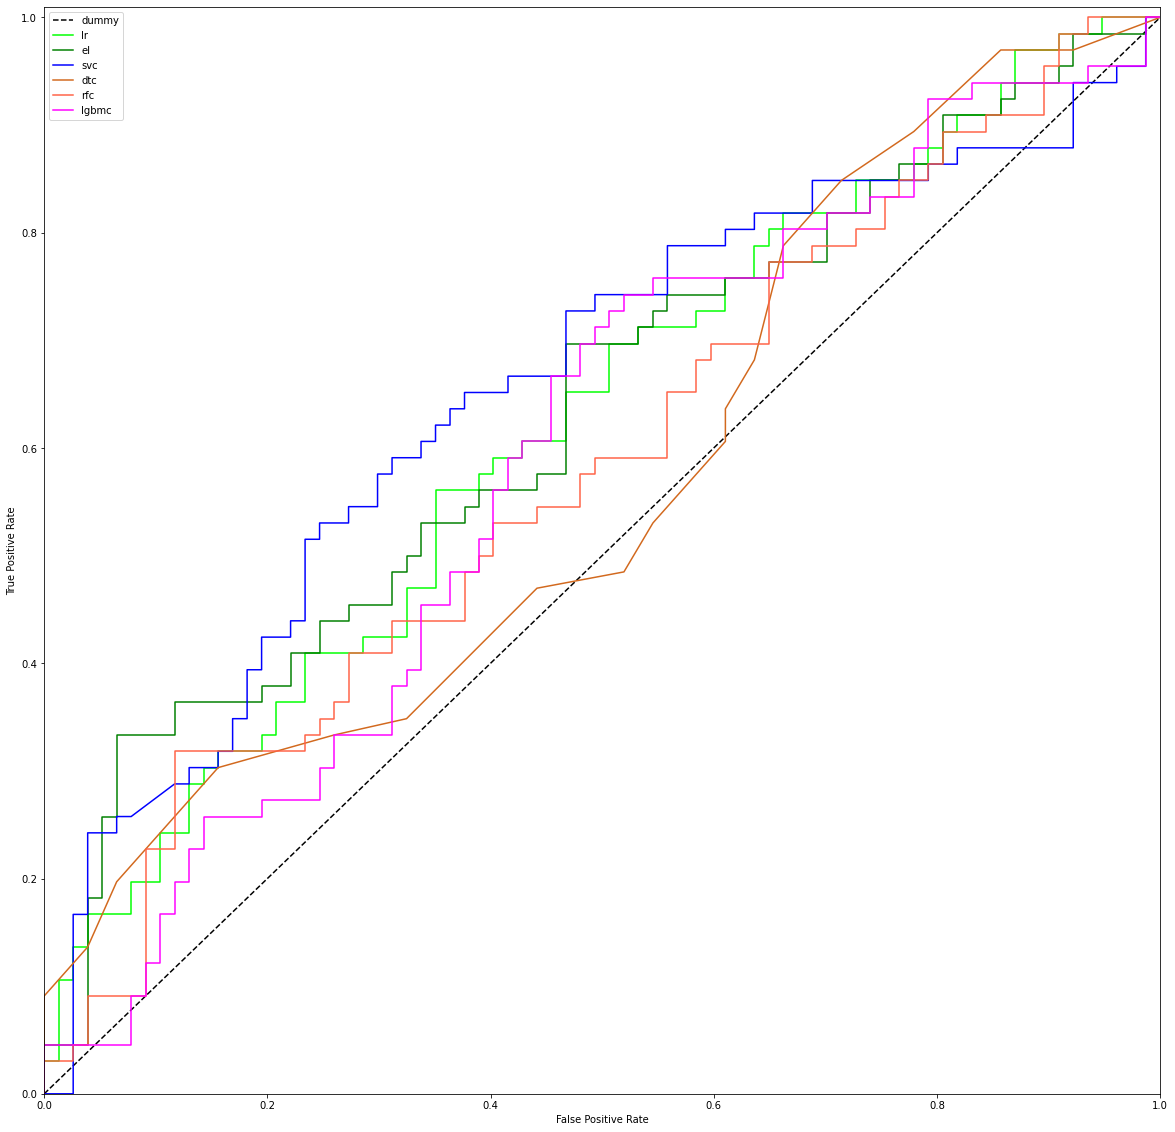

In [32]:
names = ['dummy']
plt.figure(figsize=(20, 20))
plt.plot([0, 1], [0, 1], linestyle='--', color='black')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
for name, model in trained_models_big.items():
    names.append(name)
    model_scoring(model, names, X_test_big, y_test)

Лучше всего справилась SVC, на следующем месте линейные модели. Они показали относительно высокую метрику как на валидационной, так и на тестовой выборке.

## Обучение по разнице между игроками

In [33]:
corr_matrix = train_diff.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.75)]
train_diff.drop(to_drop, axis=1, inplace=True)

In [48]:
train_diff.shape

(713, 59)

In [34]:
X_diff = train_diff.drop('who_win', axis=1)

In [35]:
X_train_diff, X_test_diff = train_test_split(X_diff, test_size=0.2, random_state=24, stratify=y)

In [36]:
trained_models_diff = train_models(models_params, X_train_diff, y_train)

Обучение модели LogisticRegression(max_iter=1000) заняло 0.88 сек или 0.01 мин
Обучение модели LogisticRegression(max_iter=1000, penalty='elasticnet', random_state=24,
                   solver='saga') заняло 167.38 сек или 2.79 мин
Обучение модели SVC(probability=True, random_state=24) заняло 56.61 сек или 0.94 мин
Обучение модели DecisionTreeClassifier(random_state=24) заняло 6.40 сек или 0.11 мин
Обучение модели RandomForestClassifier(random_state=24) заняло 72.19 сек или 1.20 мин
Обучение модели LGBMClassifier(random_state=24) заняло 27.30 сек или 0.45 мин


			 lr
Лучший ROC AUC при кросс-валидации = 0.6466506613329199
Лучшие гиперпараметры: {}
Площадь под ROC-кривой на тестовой выборке = 0.599
************************************************************
			 el
Лучший ROC AUC при кросс-валидации = 0.64362218406799
Лучшие гиперпараметры: {'el__C': 192.0034606671837, 'el__l1_ratio': 0.699512049949576}
Площадь под ROC-кривой на тестовой выборке = 0.6419
************************************************************
			 svc
Лучший ROC AUC при кросс-валидации = 0.5942553106572344
Лучшие гиперпараметры: {'svc__C': 2.548706733373507}
Площадь под ROC-кривой на тестовой выборке = 0.6236
************************************************************
			 dtc
Лучший ROC AUC при кросс-валидации = 0.60526858758814
Лучшие гиперпараметры: {'dtc__max_depth': 93, 'dtc__min_samples_leaf': 0.098097918267961, 'dtc__min_samples_split': 0.005671952810759024}
Площадь под ROC-кривой на тестовой выборке = 0.6133
********************************************************

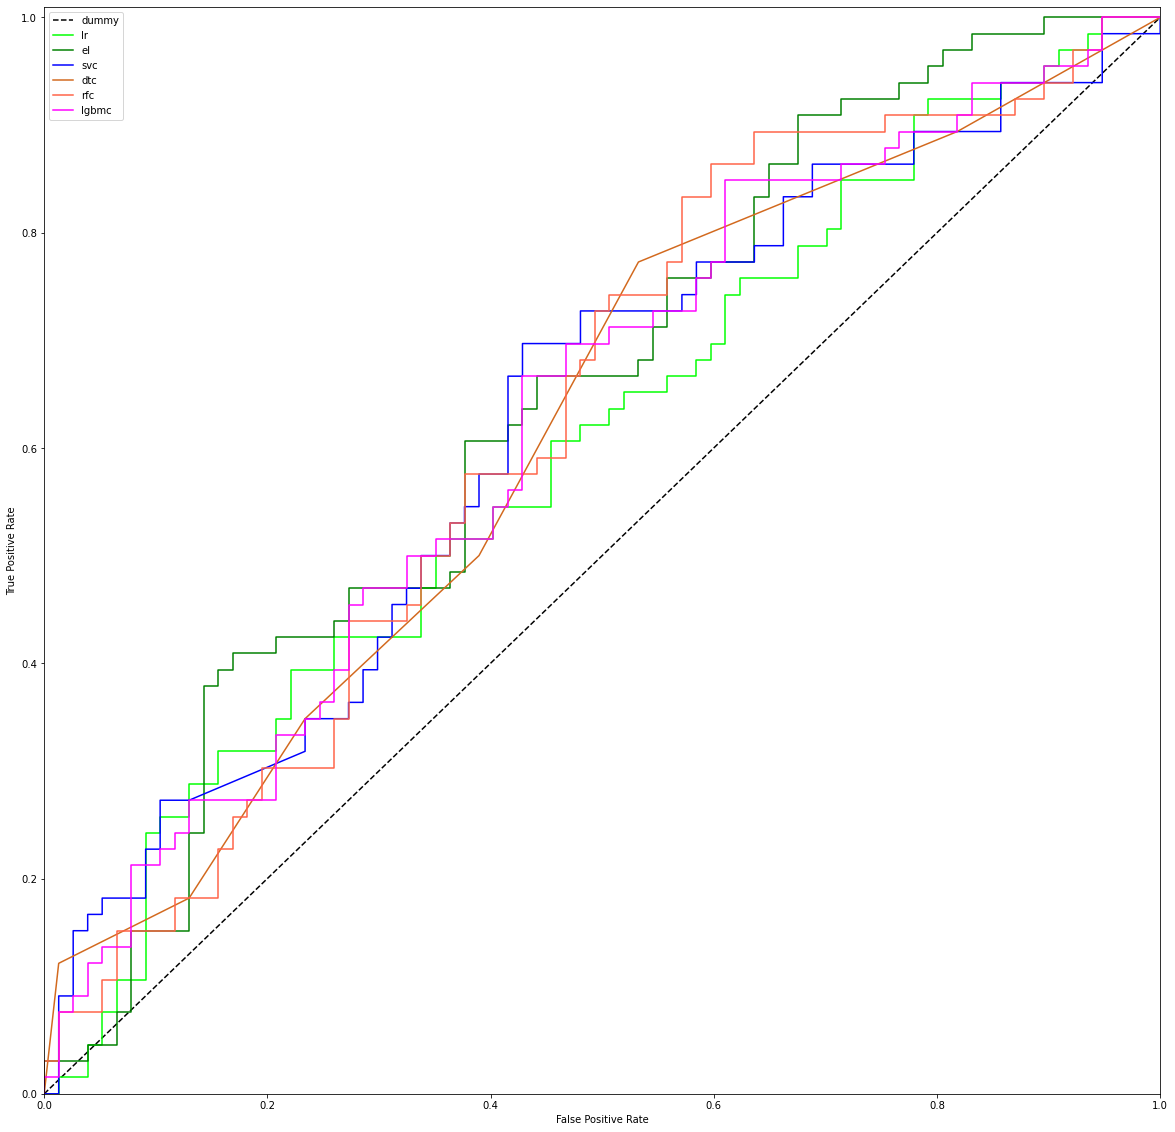

In [37]:
names = ['dummy']
plt.figure(figsize=(20, 20))
plt.plot([0, 1], [0, 1], linestyle='--', color='black')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
for name, model in trained_models_diff.items():
    names.append(name)
    model_scoring(model, names, X_test_diff, y_test)

Линейная регрессия elastic net является явным лидером.

## Обучение по разнице между усредненными значениями игроков одной команды

In [38]:
corr_matrix = train_mean_diff.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.75)]
train_mean_diff.drop(to_drop, axis=1, inplace=True)

In [49]:
train_mean_diff.shape

(713, 12)

In [39]:
X_mean_diff = train_mean_diff.drop('who_win', axis=1)

In [40]:
X_train_mean_diff, X_test_mean_diff = train_test_split(X_mean_diff, test_size=0.2, random_state=24, stratify=y)

In [41]:
trained_models_mean_diff = train_models(models_params, X_train_mean_diff, y_train)

Обучение модели LogisticRegression(max_iter=1000) заняло 0.23 сек или 0.00 мин
Обучение модели LogisticRegression(max_iter=1000, penalty='elasticnet', random_state=24,
                   solver='saga') заняло 55.76 сек или 0.93 мин
Обучение модели SVC(probability=True, random_state=24) заняло 48.98 сек или 0.82 мин
Обучение модели DecisionTreeClassifier(random_state=24) заняло 3.50 сек или 0.06 мин
Обучение модели RandomForestClassifier(random_state=24) заняло 59.59 сек или 0.99 мин
Обучение модели LGBMClassifier(random_state=24) заняло 17.67 сек или 0.29 мин


			 lr
Лучший ROC AUC при кросс-валидации = 0.6267886651229297
Лучшие гиперпараметры: {}
Площадь под ROC-кривой на тестовой выборке = 0.5401
************************************************************
			 el
Лучший ROC AUC при кросс-валидации = 0.6282135645203504
Лучшие гиперпараметры: {'el__C': 17.73079584535091, 'el__l1_ratio': 0.19938767830182724}
Площадь под ROC-кривой на тестовой выборке = 0.5419
************************************************************
			 svc
Лучший ROC AUC при кросс-валидации = 0.5932511844740076
Лучшие гиперпараметры: {'svc__C': 0.4046545188116424}
Площадь под ROC-кривой на тестовой выборке = 0.5884
************************************************************
			 dtc
Лучший ROC AUC при кросс-валидации = 0.5440276548681056
Лучшие гиперпараметры: {'dtc__max_depth': 97, 'dtc__min_samples_leaf': 0.09148277515930406, 'dtc__min_samples_split': 0.0007761558328399871}
Площадь под ROC-кривой на тестовой выборке = 0.5158
*********************************************

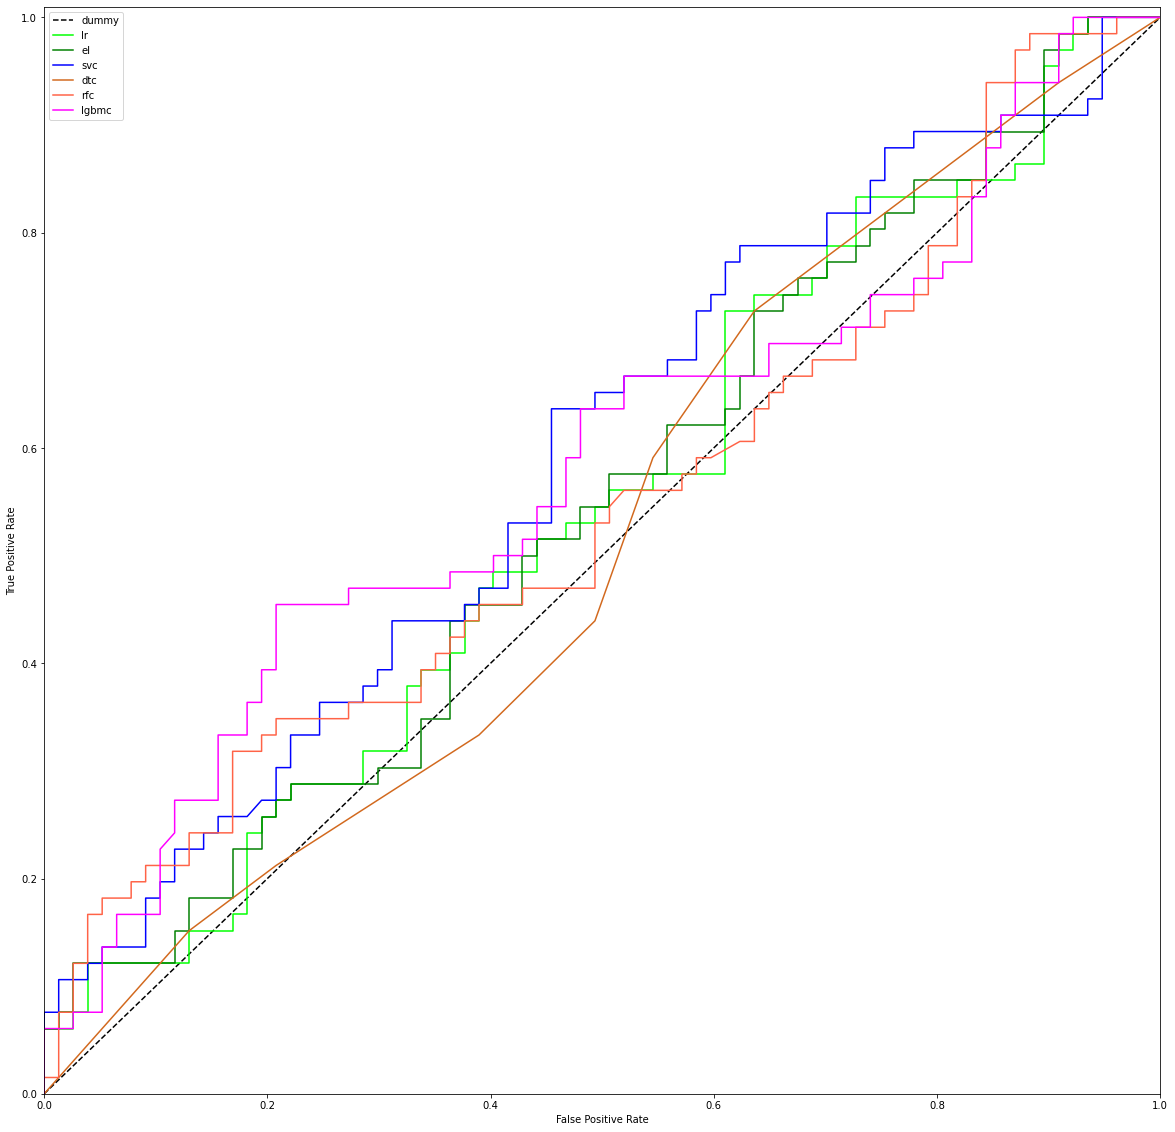

In [42]:
names = ['dummy']
plt.figure(figsize=(20, 20))
plt.plot([0, 1], [0, 1], linestyle='--', color='black')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
for name, model in trained_models_mean_diff.items():
    names.append(name)
    model_scoring(model, names, X_test_mean_diff, y_test)

Усреднение игроков снизило метрику для всех моделей.

# Предсказание
Будут сделаны 2 предсказания. На основе SVC для полного упорядоченного датасета и на основе elastic net для датасета с упорядоченными разницами между игроками.

In [43]:
svc_prediction = trained_models_big['svc'].predict(merge_big(test))
test_1 = test.copy()
test_1['who_win'] = svc_prediction 
test_1.to_csv('prediction_1.csv')

In [44]:
elastic_prediction = trained_models_diff['el'].predict(merge_diff(test))
test_2 = test.copy()
test_2['who_win'] = elastic_prediction
test_2.to_csv('prediction_2.csv')